<center><img src="images/trojan-horse.png" alt="drawing" width="7500" style="background-color:white; padding:1em;" /></center> <br/>

<div class="alert alert-block alert-success"><span style="color:blue"><h1>Trojan Detection through ML</h1></span></div>
<div class="alert alert-block alert-warning">
<span style="color:blue"><h2>Using Ensemble Learning</h2></span></div>

Ensemble methods create a strong model by combining the predictions of multiple weak models (also known as weak learners or base estimators) that are built with a given dataset and a given learning algorithm.

Three major kinds of meta-algorithms that aims at combining weak learners:

- <span style="color:red"><b>Bagging,</b></span> that often considers homogeneous weak learners, learns them independently from each other in parallel and combines them following some kind of deterministic averaging process
- <span style="color:red"><b>Boosting,</b></span> that often considers homogeneous weak learners, learns them sequentially in a very adaptative way (a base model depends on the previous ones) and combines them following a deterministic strategy
- <span style="color:red"><b>Stacking,</b></span> that often considers heterogeneous weak learners, learns them in parallel and combines them by training a meta-model to output a prediction based on the different weak models predictions

----

__Trojan Detection Dataset__

In this project, the CulinaryML team will work with historical trojan detection data in the [Trojan Detection Dataset](https://www.kaggle.com/datasets/subhajournal/trojan-detection/code). The target field of the dataset (**Class**) is the outcome of detection: <span style="color:red"><b>1 for Trojan and 0 for Benign.</b></span> Multiple features are used in the dataset.

__Dataset schema:__
<span style="color:blue">
- __ID:__ Unique ID of the Packet
- __Flow ID:__ Unique ID of the Packet Flow
- __Source IP:__ Source IP address
- __Source Port:__ Source TCP/User Datagram Protocol (UDP) ports
- __Destination IP:__ Destination IP address
- __Destination Port:__ Destination TCP/User Datagram Protocol (UDP) ports
- __Protocol:__ TCP flags and encapsulated protocol (TCP/UDP)
- __Flow Duration:__ Duration of Packet Flow
- __Total Fwd Packets:__ Number of Forward Packets
- __Total Backward Packets:__  Number of Backward Packet
- __Total Length of Fwd Packets:__ Length of Forward Packet
- __Total Length of Bwd Packets:__ Length of Backward Packet
- __Fwd Packet Length Max:__ Length of Forward Packet (Max)
- __Fwd Packet Length Min:__ Length of Forward Packet (Min)
- __Fwd Packet Length Mean:__ Length of Forward Packet (Mean)
- __Fwd Packet Length Std:__ Length of Forward Packet (STD)
- __Bwd Packet Length Max:__ Length of Backward Packet (Max)
- __Bwd Packet Length Min:__ Length of Backward Packet (Min)
- __Bwd Packet Length Mean:__ Length of Backward Packet (Mean)
- __Bwd Packet Length Std:__ Length of Backward Packet (STD)
- __Fwd IAT Total:__ IAT Total
- __Fwd Header Length:__ Length of Forward Header
- __Bwd Header Length:__ Length of Backward Header
- __Min Packet Length:__ Packet Length (Min)
- __Max Packet Length:__ Packet Length (Max)
- __Packet Length Mean:__ Packet Length (Mean)
- __Packet Length Std:__ Packet Length (STD)
- __Packet Length Variance:__ Packet Length (Variance)
- __Average Packet Size:__ Packet Size
- __Avg Fwd Segment Size:__ Forward Segment Size
- __Avg Bwd Segment Size:__ Backward Segment Size
- __Fwd Header Length.1:__ Forward Header Leader
- __Malware Type:__ 1 for Trojan and 0 for Benign
</span>
----

<center><img src="images/culinaryML.png" alt="drawing" width="500" style="background-color:white; padding:1em;" /></center>
<div class="alert alert-block alert-success">
<h1><span style="color:blue">CulinaryML Process</span></h1></div>

- [Data Collection](#Data-Collection)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Preparation](#Data-Preparation)
- [Model Building](#Model-Building)
- [Bagging](#Bagging)
- [Random Forest](#Random-Forest)
- [Boosting](#Boosting)
- [Model Evaluation](#Model-Evaluation)

---
<div class="alert alert-block alert-success">
<h1><span style="color:blue"> Data Collection</span></h1></div>

Before CulinaryML builds a model, we need to collect the data. 

In [1]:
%%capture
# Install libraries
!pip install -U -q -r requirements.txt

In [27]:
import re, string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.stem import SnowballStemmer
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
)

In [96]:
df = pd.read_csv("data/Trojan_Detection_modified.csv",sep=",")

print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (177482, 33)


In [82]:
df.head(20)

,ID,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Class
0,73217,10.42.0.42-121.14.255.84-49975-80-6,10.42.0.42,49975,121.14.255.84,80,6,10743584,4,4,...,0,672,116.000000,242.090892,58608.000000,130.500000,93.000000,168.000000,100,Trojan
1,72089,172.217.6.226-10.42.0.42-443-49169-17,10.42.0.42,49169,172.217.6.226,443,17,254217,6,7,...,30,1350,699.071429,647.514356,419274.840700,752.846154,531.833333,749.428571,204,Trojan
2,96676,10.42.0.1-10.42.0.42-53-37749-17,10.42.0.42,37749,10.42.0.1,53,17,1023244,1,1,...,30,179,79.666667,86.025190,7400.333333,119.500000,30.000000,179.000000,32,Benign
3,42891,10.42.0.1-10.42.0.42-53-41352-17,10.42.0.42,41352,10.42.0.1,53,17,286483,1,1,...,40,106,62.000000,38.105118,1452.000000,93.000000,40.000000,106.000000,20,Trojan
4,169326,10.42.0.151-107.22.241.77-44353-443-6,10.42.0.151,44353,107.22.241.77,443,6,65633087,12,10,...,0,1448,277.782609,496.257444,246271.450600,290.409091,63.916667,562.200000,392,Benign
5,34510,10.42.0.211-10.42.0.1-6021-53-17,10.42.0.211,6021,10.42.0.1,53,17,251336,1,1,...,37,182,85.333333,83.715789,7008.333333,128.000000,37.000000,182.000000,20,Trojan
6,59506,10.42.0.42-74.217.63.24-38871-443-6,10.42.0.42,38871,74.217.63.24,443,6,3096,3,0,...,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60,Trojan
7,98047,10.42.0.42-66.231.239.96-49387-443-6,10.42.0.42,49387,66.231.239.96,443,6,473,1,2,...,0,46,30.750000,21.685248,470.250000,41.000000,46.000000,15.500000,20,Benign
8,44044,10.42.0.1-10.42.0.42-53-34743-17,10.42.0.42,34743,10.42.0.1,53,17,557409,1,1,...,25,79,43.000000,31.176915,972.000000,64.500000,25.000000,79.000000,40,Trojan
9,84350,172.217.10.1-10.42.0.151-443-51786-6,172.217.10.1,443,10.42.0.151,51786,6,314,2,0,...,0,55,36.666667,31.754265,1008.333333,55.000000,27.500000,0.000000,64,Trojan


In [103]:
d = {"Benign": 0, "Trojan": 1}
df["Malware Type"] = df["Class"].map(d)

---
<div class="alert alert-block alert-success">
<h1><span style="color:blue">Exploratory Data Analysis (EDA)</span></h1></div>

CulinaryML takes an analysis approach that identifies general patterns in the data. These patterns include outliers and features of the data that might be unexpected.

In [104]:
df.head()

,ID,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Class,Malware Type
0,73217,10 42 0 42 121 14 255 84 49975 80 6,10 42 0 42,49975,121 14 255 84,80,6,10743584,4,4,...,672,116.000000,242.090892,58608.000000,130.500000,93.000000,168.000000,100,Trojan,1
1,72089,172 217 6 226 10 42 0 42 443 49169 17,10 42 0 42,49169,172 217 6 226,443,17,254217,6,7,...,1350,699.071429,647.514356,419274.840700,752.846154,531.833333,749.428571,204,Trojan,1
2,96676,10 42 0 1 10 42 0 42 53 37749 17,10 42 0 42,37749,10 42 0 1,53,17,1023244,1,1,...,179,79.666667,86.025190,7400.333333,119.500000,30.000000,179.000000,32,Benign,0
3,42891,10 42 0 1 10 42 0 42 53 41352 17,10 42 0 42,41352,10 42 0 1,53,17,286483,1,1,...,106,62.000000,38.105118,1452.000000,93.000000,40.000000,106.000000,20,Trojan,1
4,169326,10 42 0 151 107 22 241 77 44353 443 6,10 42 0 151,44353,107 22 241 77,443,6,65633087,12,10,...,1448,277.782609,496.257444,246271.450600,290.409091,63.916667,562.200000,392,Benign,0


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177482 entries, 0 to 177481
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           177482 non-null  int64  
 1   Flow ID                      177482 non-null  object 
 2   Source IP                    177482 non-null  object 
 3   Source Port                  177482 non-null  int64  
 4   Destination IP               177482 non-null  object 
 5   Destination Port             177482 non-null  int64  
 6   Protocol                     177482 non-null  int64  
 7   Flow Duration                177482 non-null  int64  
 8   Total Fwd Packets            177482 non-null  int64  
 9   Total Backward Packets       177482 non-null  int64  
 10  Total Length of Fwd Packets  177482 non-null  int64  
 11  Total Length of Bwd Packets  177482 non-null  int64  
 12  Fwd Packet Length Max        177482 non-null  int64  
 13 

In [86]:
df.describe()

,ID,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Malware Type
count,177482.000000,177482.000000,177482.000000,177482.000000,1.774820e+05,177482.000000,177482.000000,177482.000000,1.774820e+05,177482.000000,...,177482.000000,177482.000000,177482.000000,177482.000000,177482.000000,177482.000000,177482.000000,177482.000000,177482.000000,177482.000000
mean,88740.500000,38633.298729,5763.328969,8.295917,1.163310e+07,6.743929,9.908261,811.919496,1.023884e+04,230.168969,...,9.540714,403.819892,130.702537,158.057477,79742.906962,144.413807,69.020388,181.393918,197.500085,0.510942
std,51234.784576,18435.832044,15155.981517,4.540501,2.302798e+07,29.655515,106.401351,6055.745405,1.517666e+05,392.025958,...,47.188281,581.681550,214.401407,234.010789,144678.993154,223.088687,143.795809,319.797743,885.628494,0.499882
min,0.000000,0.000000,0.000000,0.000000,2.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000
25%,44370.250000,34156.000000,80.000000,6.000000,4.690050e+04,1.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000
50%,88740.500000,43105.500000,443.000000,6.000000,4.854025e+05,2.000000,1.000000,31.000000,3.100000e+01,31.000000,...,0.000000,55.000000,37.333333,20.697557,428.388889,55.000000,29.600000,15.500000,64.000000,1.000000
75%,133110.750000,52135.000000,443.000000,6.000000,1.062035e+07,5.000000,4.000000,451.000000,4.950000e+02,355.000000,...,0.000000,733.000000,158.400000,280.899324,78904.430358,185.246324,57.800000,174.795455,160.000000,1.000000
max,177481.000000,65530.000000,65267.000000,17.000000,1.199991e+08,4502.000000,12951.000000,846614.000000,1.868497e+07,1460.000000,...,1452.000000,1460.000000,1452.000000,842.931393,710533.333300,1936.000000,1460.000000,1460.000000,147364.000000,1.000000


In [54]:
df.describe(include=object)

,Flow ID,Source IP,Destination IP,Class
count,177482,177482,177482,177482
unique,96311,1794,3222,2
top,8.0.6.4-8.6.0.1-0-0-0,10.42.0.42,10.42.0.1,Trojan
freq,1067,106882,32631,90683


In [87]:
df.isnull().sum()

ID                             0
Flow ID                        0
Source IP                      0
Source Port                    0
Destination IP                 0
Destination Port               0
Protocol                       0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
Fwd Packet Length Max          0
Fwd Packet Length Min          0
Fwd Packet Length Mean         0
Fwd Packet Length Std          0
Bwd Packet Length Max          0
Bwd Packet Length Min          0
Bwd Packet Length Mean         0
Bwd Packet Length Std          0
Fwd IAT Total                  0
Fwd Header Length              0
Bwd Header Length              0
Min Packet Length              0
Max Packet Length              0
Packet Length Mean             0
Packet Length Std              0
Packet Length Variance         0
Average Packet Size            0
Avg Fwd Segment Size           0
Avg Bwd Se

<Axes: xlabel='Malware Type', ylabel='count'>

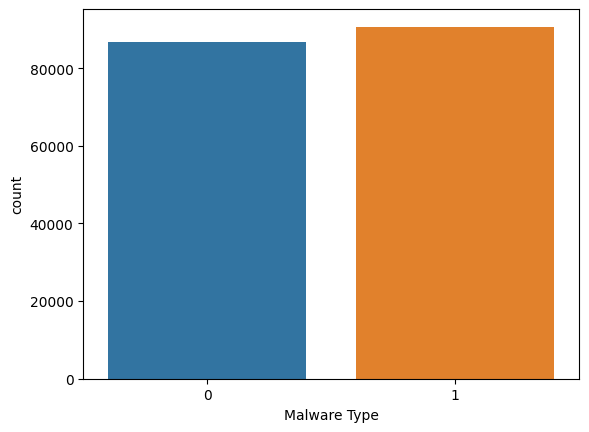

In [88]:
sns.countplot(x=df['Malware Type'])

In [89]:
print("Malware distribution from the Trojan Detection set:")
print(df['Malware Type'].value_counts())

Malware distribution from the Trojan Detection set:
Malware Type
1    90683
0    86799
Name: count, dtype: int64


In [98]:
# Create lists of the features and name the target

# Drop the IAT features: IAT and Metrics

# Numerical features 
numerical_features = [
    "ID",
    "Source Port",
    "Destination Port",
    "Protocol",
    "Flow Duration",
    "Total Backward Packets",
    "Min Packet Length",
    "Max Packet Length",
    "Packet Length Mean",
    "Packet Length Std",
    "Packet Length Variance",
    "Average Packet Size",
    "Avg Fwd Segment Size",
    "Avg Bwd Segment Size",
    "Fwd Header Length.1"
    
]


# Based on exploratory data analysis (EDA), select the text features
text_features = ["Flow ID",
                 "Source IP",
                 "Destination IP"
]

model_features = numerical_features + text_features
model_target = ['Malware Type']

df[text_features] = df[text_features].astype("str")

---
<div class="alert alert-block alert-success">
<h1><span style="color:blue">Data Processing</span></h1></div>

Next need to import and prepare the data.

---
<div class="alert alert-block alert-warning">
<h3><span style="color:blue">Clean numerical features</span></h3></div>

__Note:__ The cleaning stage can take a few minutes, depending on how much text needs to be processed.

In [105]:
# Prepare cleaning functions

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer("english")


def preProcessText(text):
    # Lowercase text, and strip leading and trailing white space
    text = text.lower().strip()

    # Remove HTML tags
    text = re.compile("<.*?>").sub("", text)

    # Remove punctuation
    text = re.compile("[%s]" % re.escape(string.punctuation)).sub(" ", text)

    # Remove extra white space
    text = re.sub("\s+", " ", text)

    return text


def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)

    return text


def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)


# Clean the text features
for c in text_features:
    print("Text cleaning: ", c)
    df[c] = [cleanSentence(item, stop_words, stemmer) for item in df[c].values]

Text cleaning:  Flow ID
Text cleaning:  Source IP
Text cleaning:  Destination IP


---
<div class="alert alert-block alert-warning">
<h3><span style="color:blue">Create training and test datasets</span></h3></div>


As part of data preparation, the dataset is split into training and test subsets by using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

For this notebook, you will use 80 percent of the data for the training set and 20 percent for the test set. Determine the best split based on the size of your dataset.

In [106]:
train_data, test_data = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=23
)

The data is now prepared, and you are ready to create a bagging classifier.

---
<div class="alert alert-block alert-success">
<h1><span style="color:blue">Data Modeling</span></h1></div>

---
<div class="alert alert-block alert-success">
<h2><span style="color:blue">Bagging</span></h2></div>


   (**Malware Type**) is the outcome of adoption:<span style="color:red"><b> 1 for trojan and 0 for benign.</b></span>

<center><img src="Hyperparameter_Optimization_using_Grid_Search.svg.png" alt="drawing" width="800" style="background-color:white; padding:1em;" /></center>

In this section, you will build your first ensemble model by using the bootstrap aggregating, or bagging, approach. With this approach, you randomly draw multiple data subsets from the training set (with replacement) and train one model for each subset.

The first approach will use multiple trees in the bagging model.

---
<div class="alert alert-block alert-warning">
<h3><span style="color:blue">Data processing with a pipeline and a bagging ColumnTransformer</span></h3></div>


You need to use different pipelines to handle the numerical, categorical, and text features. Then, you will combine them into a composite pipeline along with an estimator. To do this, you will use a [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html).

In [107]:
### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline(
    [
        (
            "num_scaler",
            MinMaxScaler(),
        )  # Shown in case it is needed. Not a must with decision trees.
    ]
)

# Preprocess the categorical features
# handle_unknown tells it to ignore (rather than throw an error for) any value
# that was not present in the initial training set.
categorical_processor = Pipeline(
    [("cat_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

# Preprocess the text feature
text_processor_0 = Pipeline(
    [("text_vect_0", CountVectorizer(binary=True, max_features=150))]
)

# Combine all data preprocessors from above (add more if you choose to define more)
# For each processor/step, specify a name, the actual process, and the features to be processed
data_preprocessor = ColumnTransformer(
    [
        ("numerical_pre", numerical_processor, numerical_features),
        ("categorical_pre", categorical_processor, categorical_features),
        ("text_pre_0", text_processor_0, text_features[0]),
    ]
)

### PIPELINE ###
################

# Pipeline with all desired data transformers, along with an estimator
# Later, you can set/reach the parameters by using the names issued - for hyperparameter tuning, for example

#####################################################
### Notice the pipeline using a BaggingClassifier ###
#####################################################
pipeline = Pipeline(
    [
        ("data_preprocessing", data_preprocessor),
        (
            "bg",
            BaggingClassifier(
                DecisionTreeClassifier(max_depth=25),  # Each tree has max_depth=25
                n_estimators=10,
            ),
        ),
    ]
)  # Use 10 trees

# Visualize the pipeline
# This will be helpful especially when building more complex pipelines,
# stringing together multiple preprocessing steps
from sklearn import set_config

set_config(display="diagram")
pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['ID', 'Source Port',
                                                   'Destination Port',
                                                   'Protocol', 'Flow Duration',
                                                   'Total Backward Packets',
                                                   'Min Packet Length',
                                                   'Max Packet Length',
                                                   'Packet Length Mean',
                                                   'Packet Length Std',
                                                   'Packet Length Variance',
                                                   'Average Packet Size',
                                                   'Avg Fwd Segment Size',
                                                   'Avg Bwd Segment Size',
                                                   'Fwd Header Length.1']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Source IP',
                                                   'Destination IP']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'Flow ID')])),
                ('bg',
                 BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=25)))])

Now you can fit the bagging model, and see the training and test scores.

In [108]:
# Get training data to train the pipeline
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Use the fitted pipeline to make predictions on the training dataset
train_predictions = pipeline.predict(X_train)
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Accuracy (training):", accuracy_score(y_train, train_predictions))

# Get testing data to test the pipeline
X_test = test_data[model_features]
y_test = test_data[model_target]

# Use the fitted pipeline to make predictions on the testing dataset
test_predictions = pipeline.predict(X_test)
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Accuracy (test):", accuracy_score(y_test, test_predictions))

/Users/v.henry/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[69522     0]
 [    0 72463]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69522
           1       1.00      1.00      1.00     72463

    accuracy                           1.00    141985
   macro avg       1.00      1.00      1.00    141985
weighted avg       1.00      1.00      1.00    141985

Accuracy (training): 1.0
[[17277     0]
 [    0 18220]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17277
           1       1.00      1.00      1.00     18220

    accuracy                           1.00     35497
   macro avg       1.00      1.00      1.00     35497
weighted avg       1.00      1.00      1.00     35497

Accuracy (test): 1.0


<center><img src="Confusion Matrix.png" alt="drawing" width="500" style="background-color:white; padding:1em;" /></center>


Using a bagging classifier isn't difficult because it only requires updating one line of code.

Next, you will create a random forest model.

---
<div class="alert alert-block alert-success">
<h1><span style="color:blue">Random forest</span></h1></div>


Now, you will try the second ensemble model: random forest. Random forest involves a similar ensemble process:
- Draw random subsets (with replacement) from the original dataset.
- Train individual trees with each subset.

However, a difference is that random forest uses a randomly selected feature subset for each tree. As a rule of thumb, pick the `sqrt(# features)` as the number of random features for each tree and don't use any other features.


The model is called in a similar way to the bagging method. You will replace the BaggingClassifier with a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) in the pipeline.

In [109]:
### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline(
    [
        (
            "num_scaler",
            MinMaxScaler(),
        )  # Shown in case it is needed. Not a must with decision trees.
    ]
)

# Preprocess the categorical features
# handle_unknown tells it to ignore (rather than throw an error for) any value
# that was not present in the initial training set.
categorical_processor = Pipeline(
    [("cat_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

# Preprocess the text feature
text_processor_0 = Pipeline(
    [("text_vect_0", CountVectorizer(binary=True, max_features=150))]
)

# Combine all data preprocessors (add more if you choose to define more)
# For each processor/step, specify a name, the actual process, and the features to be processed
data_preprocessor = ColumnTransformer(
    [
        ("numerical_pre", numerical_processor, numerical_features),
        ("categorical_pre", categorical_processor, categorical_features),
        ("text_pre_0", text_processor_0, text_features[0]),
    ]
)

### PIPELINE ###
################

# Pipeline with all desired data transformers, along with an estimator
# Later, you can set/reach the parameters by using the names issued - for hyperparameter tuning, for example

##########################################################
### Notice the pipeline using a RandomForestClassifier ###
##########################################################
pipeline = Pipeline(
    [
        ("data_preprocessing", data_preprocessor),
        (
            "rf",
            RandomForestClassifier(
                max_depth=25, n_estimators=100  # Each tree has max_depth=25
            ),
        ),
    ]
)  # Use 100 trees

# Visualize the pipeline
# This will be helpful especially when building more complex pipelines,
# stringing together multiple preprocessing steps
from sklearn import set_config

set_config(display="diagram")
pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['ID', 'Source Port',
                                                   'Destination Port',
                                                   'Protocol', 'Flow Duration',
                                                   'Total Backward Packets',
                                                   'Min Packet Length',
                                                   'Max Packet Length',
                                                   'Packet Length Mean',
                                                   'Packet Length Std',
                                                   'Packet Length Variance',
                                                   'Average Packet Size',
                                                   'Avg Fwd Segment Size',
                                                   'Avg Bwd Segment Size',
                                                   'Fwd Header Length.1']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Source IP',
                                                   'Destination IP']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'Flow ID')])),
                ('rf', RandomForestClassifier(max_depth=25))])

Now you can fit the random forest model, and see the training and test scores.

In [110]:
# Get training data to train the pipeline
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Use the fitted pipeline to make predictions on the training dataset
train_predictions = pipeline.predict(X_train)
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Accuracy (training):", accuracy_score(y_train, train_predictions))

# Get testing data to test the pipeline
X_test = test_data[model_features]
y_test = test_data[model_target]

# Use the fitted pipeline to make predictions on the testing dataset
test_predictions = pipeline.predict(X_test)
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Accuracy (test):", accuracy_score(y_test, test_predictions))

/Users/v.henry/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[[69099   423]
 [   31 72432]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     69522
           1       0.99      1.00      1.00     72463

    accuracy                           1.00    141985
   macro avg       1.00      1.00      1.00    141985
weighted avg       1.00      1.00      1.00    141985

Accuracy (training): 0.9968024791351199
[[17077   200]
 [   19 18201]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17277
           1       0.99      1.00      0.99     18220

    accuracy                           0.99     35497
   macro avg       0.99      0.99      0.99     35497
weighted avg       0.99      0.99      0.99     35497

Accuracy (test): 0.9938304645462996


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="images/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">You can perform hyperparameter tuning on a random forest model.</p><br>
    <p style=" text-align: center; margin: auto;">In the following code cell, run a grid search with the random forest classifier using <code>param_grid={'rf__max_depth': [25, 30, 45]}</code>.</p><br>
    <p style=" text-align: center; margin: auto;">What is the best hyperparameter value after this run?</p>
    <br>
</div>

In [111]:
# Write your code for grid search with param_grid={'rf__max_depth': [25, 30, 45]}

# Parameter grid for GridSearch

############### CODE HERE ###############

from scipy.stats import randint
# Parameter grid for GridSearch

param_grid = {
    'rf__max_depth': [25, 30, 45]
}


grid_search = GridSearchCV(
    pipeline,  # Base model
    param_grid,  # Parameters to try
    cv=5,  # Apply 5-fold cross validation
    verbose=1,  # Print summaryGridSearchCV
    n_jobs=-1,  # Use all available processors
)

# Fit the RandomizedSearch to the training data
grid_search.fit(X_train, y_train)


############## END OF CODE ##############

print(grid_search.best_params_)
print(grid_search.best_score_)

# Get the best model out of GridSearchCV
classifier = grid_search.best_estimator_

# Fit the best model to the training data
classifier.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/v.henry/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/v.henry/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/v.henry/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/v.henry/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

{'rf__max_depth': 45}
0.9989998943550376


/Users/v.henry/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['ID', 'Source Port',
                                                   'Destination Port',
                                                   'Protocol', 'Flow Duration',
                                                   'Total Backward Packets',
                                                   'Min Packet Length',
                                                   'Max Packet Length',
                                                   'Packet Length Mean',
                                                   'Packet Length Std',
                                                   'Packet Length Variance',
                                                   'Average Packet Size',
                                                   'Avg Fwd Segment Size',
                                                   'Avg Bwd Segment Size',
                                                   'Fwd Header Length.1']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Source IP',
                                                   'Destination IP']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'Flow ID')])),
                ('rf', RandomForestClassifier(max_depth=45))])

In [112]:
# Get testing data to test the classifier
X_test = test_data[model_features]
y_test = test_data[model_target]

# Use the fitted model to make predictions on the test dataset
# Testing data going through the pipeline is first imputed
# (with means from the training set), scaled (with the min/max from the training data),
# and finally used to make predictions.
test_predictions = classifier.predict(X_test)

print("Model performance on the test set:")
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
[[17260    17]
 [    3 18217]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17277
           1       1.00      1.00      1.00     18220

    accuracy                           1.00     35497
   macro avg       1.00      1.00      1.00     35497
weighted avg       1.00      1.00      1.00     35497

Test accuracy: 0.999436572104685


---
<div class="alert alert-block alert-success">
<h1><span style="color:blue">Boosting</span></h1></div>

The last ensemble model that you will try is boosting. This method builds multiple weak models sequentially. Each subsequent model attempts to boost performance overall by overcoming or reducing the errors of the previous model.

You will use sklearn's [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) in the pipeline.

In [113]:
### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline(
    [
        (
            "num_scaler",
            MinMaxScaler(),
        )  # Shown in case it is needed. Not a must with decision trees.
    ]
)

# Preprocess the categorical features
# handle_unknown tells it to ignore (rather than throw an error for) any value
# that was not present in the initial training set.
categorical_processor = Pipeline(
    [("cat_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

# Preprocess the text feature
text_processor_0 = Pipeline(
    [("text_vect_0", CountVectorizer(binary=True, max_features=150))]
)

# Combine all data preprocessors (add more if you choose to define more)
# For each processor/step, specify a name, the actual process, and the features to be processed
data_preprocessor = ColumnTransformer(
    [
        ("numerical_pre", numerical_processor, numerical_features),
        ("categorical_pre", categorical_processor, categorical_features),
        ("text_pre_0", text_processor_0, text_features[0]),
    ]
)

### PIPELINE ###
################

# Pipeline with all desired data transformers, along with an estimator
# Later, you can set/reach the parameters by using the names issued - for hyperparameter tuning, for example

##############################################################
### Notice the pipeline using a GradientBoostingClassifier ###
##############################################################
pipeline = Pipeline(
    [
        ("data_preprocessing", data_preprocessor),
        (
            "gbc",
            GradientBoostingClassifier(
                max_depth=10, n_estimators=100  # Each tree has max_depth=10
            ),
        ),
    ]
)  # Use 100 trees

# Visualize the pipeline
# This will be helpful especially when building more complex pipelines,
# stringing together multiple preprocessing steps
from sklearn import set_config

set_config(display="diagram")
pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['ID', 'Source Port',
                                                   'Destination Port',
                                                   'Protocol', 'Flow Duration',
                                                   'Total Backward Packets',
                                                   'Min Packet Length',
                                                   'Max Packet Length',
                                                   'Packet Length Mean',
                                                   'Packet Length Std',
                                                   'Packet Length Variance',
                                                   'Average Packet Size',
                                                   'Avg Fwd Segment Size',
                                                   'Avg Bwd Segment Size',
                                                   'Fwd Header Length.1']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Source IP',
                                                   'Destination IP']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'Flow ID')])),
                ('gbc', GradientBoostingClassifier(max_depth=10))])

Now fit the model, and see the training and testing scores.

In [114]:
# Get training data to train the pipeline
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Use the fitted pipeline to make predictions on the training dataset
train_predictions = pipeline.predict(X_train)
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Accuracy (training):", accuracy_score(y_train, train_predictions))

# Get testing data to test the pipeline
X_test = test_data[model_features]
y_test = test_data[model_target]

# Use the fitted pipeline to make predictions on the testing dataset
test_predictions = pipeline.predict(X_test)
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Accuracy (test):", accuracy_score(y_test, test_predictions))

/Users/v.henry/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[69522     0]
 [    0 72463]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69522
           1       1.00      1.00      1.00     72463

    accuracy                           1.00    141985
   macro avg       1.00      1.00      1.00    141985
weighted avg       1.00      1.00      1.00    141985

Accuracy (training): 1.0
[[17277     0]
 [    1 18219]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17277
           1       1.00      1.00      1.00     18220

    accuracy                           1.00     35497
   macro avg       1.00      1.00      1.00     35497
weighted avg       1.00      1.00      1.00     35497

Accuracy (test): 0.9999718286052343


---
<div class="alert alert-block alert-success">
<h1><span style="color:blue">Conclusion</span></h1></div>

This notebook provided an introduction to using Bagging, RandomForest, and GradientBoosting classifiers on the same dataset.

---
<div class="alert alert-block alert-success">
<h1><span style="color:blue">Next Lab</span></h1></div>

In the next lab, you will be introduced to fairness and bias mitigation in ML by exploring different types of bias that are present in data and practicing how to build various documentation sheets.